In [1]:
import codecs
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from imblearn.under_sampling import RandomUnderSampler

# Смотрим на тестовые данные

In [2]:
with codecs.open('test.csv', 'r', encoding='utf-8') as f:
    test_text = f.read()
    soup = BeautifulSoup(test_text, 'html.parser')
    test_reviews = soup.findAll('review')
    test_list = [test_review.text for test_review in test_reviews]

In [3]:
test = pd.DataFrame(test_list, columns=['text'])
test

,text
0,"Ужасно слабый аккумулятор, это основной минус ..."
1,ценанадежность-неубиваемостьдолго держит батар...
2,"подробнее в комментариях\nК сожалению, факт по..."
3,я любительница громкой музыки. Тише телефона у...
4,"Дата выпуска - 2011 г, емкость - 1430 mAh, тех..."
...,...
95,"Нет передней камеры, внутренняя память очень м..."
96,"Звук при прослушивание музыки хороший,не глючи..."
97,Очень маленькая память забита вшитыми и соверш...
98,"Удобный корпус,стандартное меню нокиа,камера д..."


# Загружаем данные для обучения

In [4]:
X_test = test['text'].values

In [5]:
train = pd.read_json('train_yandex_market.json', lines=True, encoding="utf8")

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63488 entries, 0 to 63487
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    63488 non-null  object
 1   rating  63488 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 992.1+ KB


In [7]:
train.head()

,text,rating
0,"несколько месяцев Смартфон, действительно очен...",5
1,"менее месяца яркость экрана, 5000 мач, удобно ...",5
2,"менее месяца Удобно лежит в руке, отличные фот...",5
3,"менее месяца Обычный смартфон, хорошее качеств...",4
4,несколько месяцев Хорошая связь. 4g_3g мобильн...,4


Text(0, 0.5, 'Количество оценок')

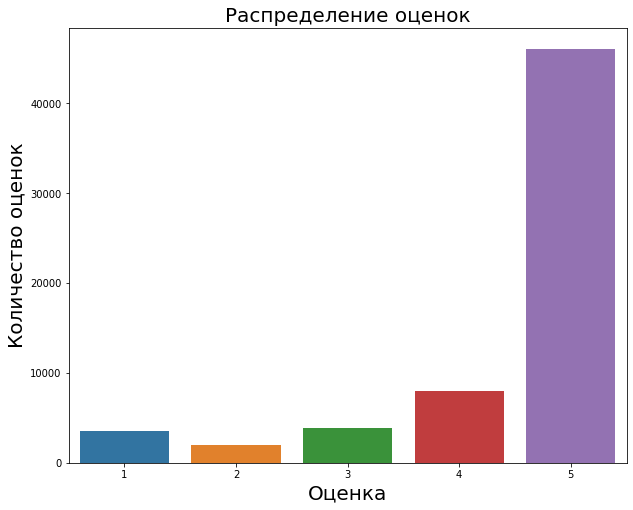

In [8]:
countplt, ax = plt.subplots(figsize = (10,8))
ax = sns.countplot(data=train, x='rating')
ax.set_title('Распределение оценок', fontsize=20)
ax.set_xlabel('Оценка', fontsize=20)
ax.set_ylabel('Количество оценок', fontsize=20)

In [9]:
train['length'] = train['text'].apply(len)

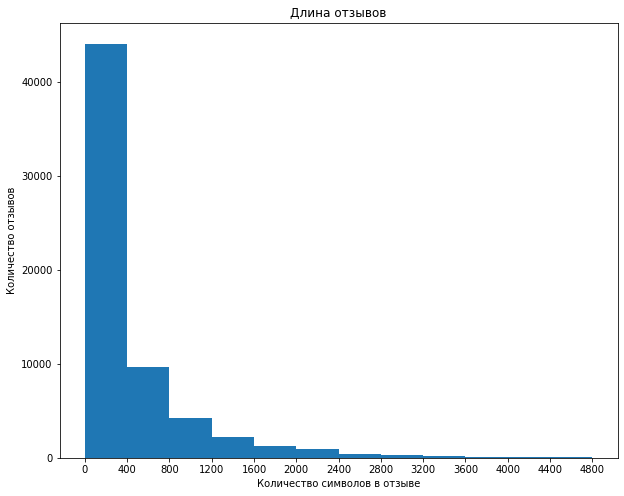

In [10]:
hist, ax = plt.subplots(figsize = (10,8))
ax = train.length.plot(kind='hist', bins=np.arange(0, 5000, 400))
ax.set_title('Длина отзывов')
ax.set_xlabel('Количество символов в отзыве')
ax.set_ylabel('Количество отзывов')
ax.set_xticks(np.arange(0, 5000, 400))

In [11]:
train.quantile(0.95)

rating       5.0
length    1629.0
Name: 0.95, dtype: float64

# Удаляем лишнее из отзывов

In [12]:
def cleaning(text):
    try:
        text = re.sub(r'Достоинства', ' ', text)
        text = re.sub(r'Недостатки', ' ', text)
        text = re.sub(r'Комментарий', ' ', text)
        text = re.sub(r'менее месяца', ' ', text)
        text = re.sub(r'более года', ' ', text)
        text = re.sub(r'несколько месяцев', ' ', text)
        text = ' '.join(text.split())
        return text
    except:
        return text

In [13]:
train['text'] = train.apply(lambda x: cleaning(x['text']), axis=1)
train['label'] = train['rating'].apply(lambda x: int(x == 5))

Text(0, 0.5, 'Количество оценок')

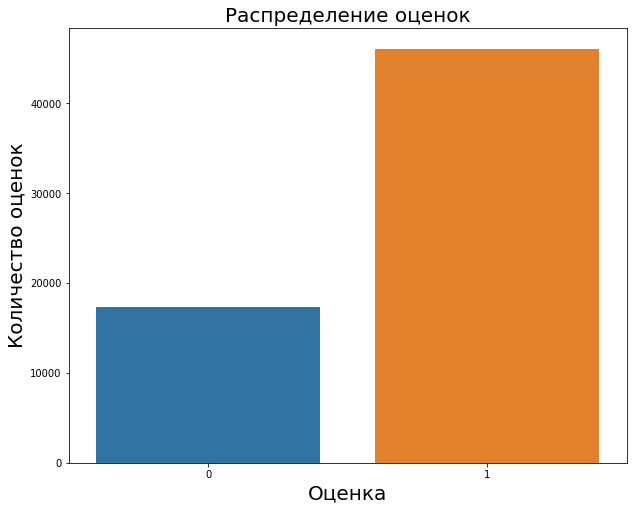

In [14]:
countplt, ax = plt.subplots(figsize = (10,8))
ax = sns.countplot(data=train, x='label')
ax.set_title('Распределение оценок', fontsize=20)
ax.set_xlabel('Оценка', fontsize=20)
ax.set_ylabel('Количество оценок', fontsize=20)

# Балансируем выборку

In [15]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(train['text']), train['label'])
X_resampled, y_resampled = X_resampled.values.flatten(), y_resampled.values.flatten()

Text(0, 0.5, 'Количество оценок')

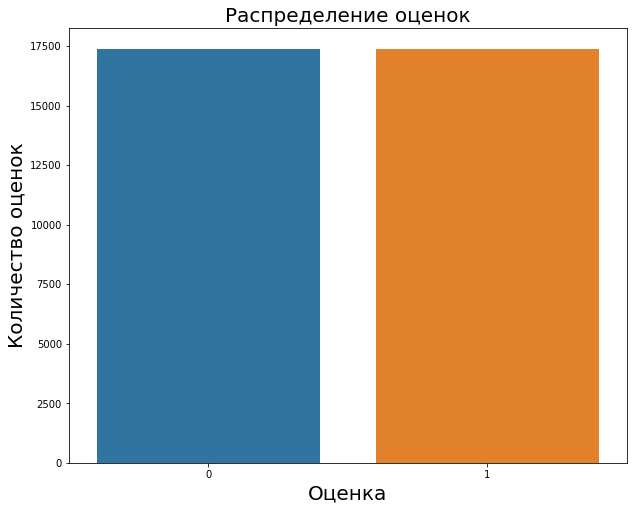

In [16]:
train = pd.DataFrame({'text': X_resampled, 'label' :y_resampled})
countplt, ax = plt.subplots(figsize = (10,8))
ax = sns.countplot(data=train, x='label')
ax.set_title('Распределение оценок', fontsize=20)
ax.set_xlabel('Оценка', fontsize=20)
ax.set_ylabel('Количество оценок', fontsize=20)

# Производим подбор оптимальных гиперпараметров и модели

In [17]:
def make_pipeline(vectorizer, transformer, classifier):
    return Pipeline([
        ('vectorizer', vectorizer),
        ('transformer', transformer),
        ('classifier', classifier)
    ])

In [15]:
def make_estimator(classifier, params_grid, scorer, data, labels):
    pipeline = make_pipeline(TfidfVectorizer(), TfidfTransformer(), classifier)
    grid_cv = RandomizedSearchCV(pipeline, params_grid, scoring=scorer, cv=5, random_state=42, n_iter=100, verbose=True,
                                 n_jobs=-2)
    grid_cv.fit(data, labels)
    return grid_cv

In [16]:
parameters_grid_vectorizer = {
    'vectorizer__ngram_range': [(1, 2), (1, 3)],
    'vectorizer__min_df': [1, 2, 3],
    'vectorizer__max_df': [0.95, 1.0],
}

In [17]:
parameters_grid_transformer = {
    'transformer__use_idf': [False, True],
    'transformer__sublinear_tf': [True, False],
    'transformer__smooth_idf': [False, True],
    'transformer__norm': ['l2', 'l1']
}

In [18]:
parameters_grid_lr = {
    'classifier__C': [0.8, 0.9, 1.1, 1.2],
    'classifier__max_iter': [45, 50, 75, 90],
    'classifier__solver': ['newton-cg', 'lbfgs', 'sag'],
    'classifier__penalty': ['l2'],
}
parameters_grid_lsvc = {
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__max_iter': np.arange(200, 1000, 200),
    'classifier__tol': [1e-5, 1e-4, 1e-3],
    'classifier__C': [0.7, 0.9, 1.1, 1.3]
}
parameters_grid_svc = {
    'classifier__C': [1, 10, 100, 1000],
    'classifier__gamma': [1, 0.1, 0.001, 0.0001],
    'classifier__kernel': ['linear', 'rbf']
}
parameters_grid_lgb = {
    'classifier__num_leaves': (10, 22, 31, 40),
    'classifier__learning_rate': (0, 0.01, 0.05, 0.1),
    'classifier__colsample_bytree': (0.7, 0.8, 0.9, 1)
}
parameters_grid_rf = {
    'classifier__n_estimators': [150, 200, 250],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth': [8, 10, 12, 16, 20, 24],
    'classifier__criterion': ['gini', 'entropy']
}

In [19]:
%%time
LGB_grid_search = make_estimator(lgb.LGBMClassifier(),
                                 {**parameters_grid_vectorizer, **parameters_grid_transformer, **parameters_grid_lgb},
                                 'accuracy',
                                 np.concatenate([X_resampled[:900], X_resampled[18000:18900]]),
                                 np.concatenate([y_resampled[:900], y_resampled[18000:18900]]))

UsageError: Line magic function `%` not found.


In [45]:
print(LGB_grid_search.best_score_, LGB_grid_search.best_params_)

0.723888888888889 {'vectorizer__ngram_range': (1, 3), 'vectorizer__min_df': 3, 'vectorizer__max_df': 1.0, 'transformer__use_idf': False, 'transformer__sublinear_tf': False, 'transformer__smooth_idf': False, 'transformer__norm': 'l2', 'classifier__num_leaves': 40, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 1}


In [28]:
%%time
LR_grid_search = make_estimator(LogisticRegression(random_state=42),
                                {**parameters_grid_vectorizer, **parameters_grid_transformer, **parameters_grid_lr},
                                'accuracy',
                                np.concatenate([X_resampled[:900], X_resampled[18000:18900]]),
                                np.concatenate([y_resampled[:900], y_resampled[18000:18900]]))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 4.36 s
Wall time: 1min 11s


In [29]:
print(LR_grid_search.best_score_, LR_grid_search.best_params_)

0.7744444444444444 {'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 2, 'vectorizer__max_df': 0.95, 'transformer__use_idf': True, 'transformer__sublinear_tf': False, 'transformer__smooth_idf': True, 'transformer__norm': 'l2', 'classifier__solver': 'sag', 'classifier__penalty': 'l2', 'classifier__max_iter': 90, 'classifier__C': 0.9}


In [46]:
% % time
LSVC_grid_search = make_estimator(LinearSVC(random_state=42),
                                  {**parameters_grid_vectorizer, **parameters_grid_transformer, **parameters_grid_lsvc},
                                  'accuracy',
                                  np.concatenate([X_resampled[:900], X_resampled[18000:18900]]),
                                  np.concatenate([y_resampled[:900], y_resampled[18000:18900]]))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 3.31 s
Wall time: 50.1 s


In [47]:
print(LSVC_grid_search.best_score_, LSVC_grid_search.best_params_)

0.7738888888888888 {'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.95, 'transformer__use_idf': True, 'transformer__sublinear_tf': True, 'transformer__smooth_idf': True, 'transformer__norm': 'l2', 'classifier__tol': 0.001, 'classifier__max_iter': 200, 'classifier__loss': 'squared_hinge', 'classifier__C': 1.1}


In [53]:
% % time
SVC_grid_search = make_estimator(SVC(random_state=42),
                                 {**parameters_grid_vectorizer, **parameters_grid_transformer, **parameters_grid_svc},
                                 'accuracy',
                                 np.concatenate([X_resampled[:900], X_resampled[18000:18900]]),
                                 np.concatenate([y_resampled[:900], y_resampled[18000:18900]]))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 5.42 s
Wall time: 2min 42s


In [54]:
print(SVC_grid_search.best_score_, SVC_grid_search.best_params_)

0.7672222222222221 {'vectorizer__ngram_range': (1, 3), 'vectorizer__min_df': 1, 'vectorizer__max_df': 1.0, 'transformer__use_idf': True, 'transformer__sublinear_tf': True, 'transformer__smooth_idf': False, 'transformer__norm': 'l2', 'classifier__kernel': 'linear', 'classifier__gamma': 0.001, 'classifier__C': 1}


In [64]:
%%time
RF_grid_search = make_estimator(RandomForestClassifier(random_state=42),
                                {**parameters_grid_vectorizer, **parameters_grid_transformer, **parameters_grid_rf},
                                'accuracy',
                                np.concatenate([X_resampled[:900], X_resampled[18000:18900]]),
                                np.concatenate([y_resampled[:900], y_resampled[18000:18900]]))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 3.59 s
Wall time: 1min 59s


In [65]:
print(RF_grid_search.best_score_, RF_grid_search.best_params_)

0.7005555555555556 {'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 2, 'vectorizer__max_df': 1.0, 'transformer__use_idf': False, 'transformer__sublinear_tf': True, 'transformer__smooth_idf': True, 'transformer__norm': 'l2', 'classifier__n_estimators': 150, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 20, 'classifier__criterion': 'entropy'}


# Обучаем модель

In [18]:
%%time
LR = make_pipeline(CountVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.95),
                   TfidfTransformer(smooth_idf=False),
                   LogisticRegression(solver='sag', max_iter=90, C=0.9))
LR.fit(X_resampled, y_resampled)

CPU times: total: 7.89 s
Wall time: 8.2 s


Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))),
                ('transformer', TfidfTransformer(smooth_idf=False)),
                ('classifier',
                 LogisticRegression(C=0.9, max_iter=90, solver='sag'))])

In [32]:
predLR = LR.predict(X_test)

In [33]:
%%time
LGB = make_pipeline(CountVectorizer(ngram_range=(1, 3), min_df=3, max_df=1.0),
                   TfidfTransformer(smooth_idf=False),
                   lgb.LGBMClassifier(num_leaves=40, learning_rate=0.05, colsample_bytree=1))
LGB.fit(X_resampled, y_resampled)

CPU times: total: 2min 57s
Wall time: 39.1 s


Pipeline(steps=[('vectorizer', CountVectorizer(min_df=3, ngram_range=(1, 3))),
                ('transformer', TfidfTransformer(smooth_idf=False)),
                ('classifier',
                 LGBMClassifier(colsample_bytree=1, learning_rate=0.05,
                                num_leaves=40))])

In [34]:
predLGB = LGB.predict(X_test)

In [37]:
%%time
LSVC = make_pipeline(CountVectorizer(ngram_range=(1, 2), min_df=1, max_df=0.95),
                    TfidfTransformer(smooth_idf=True),
                    LinearSVC(tol=0.001, max_iter=200, loss='squared_hinge', C=1.1))
LSVC.fit(X_resampled, y_resampled)

CPU times: total: 11.2 s
Wall time: 11.7 s


Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.95, ngram_range=(1, 2))),
                ('transformer', TfidfTransformer()),
                ('classifier', LinearSVC(C=1.1, max_iter=200, tol=0.001))])

In [38]:
predLSVC = LSVC.predict(X_test)

In [41]:
%%time
SVC = make_pipeline(CountVectorizer(ngram_range=(1, 3), min_df=1, max_df=1.0),
                     TfidfTransformer(smooth_idf=False),
                     SVC(kernel='linear', gamma=0.001, C=1))
SVC.fit(X_resampled, y_resampled)

CPU times: total: 38min 31s
Wall time: 38min 44s


Pipeline(steps=[('vectorizer', CountVectorizer(ngram_range=(1, 3))),
                ('transformer', TfidfTransformer(smooth_idf=False)),
                ('classifier', SVC(C=1, gamma=0.001, kernel='linear'))])

In [42]:
predSVC = SVC.predict(X_test)

In [44]:
%%time
RF = make_pipeline(CountVectorizer(ngram_range=(1, 2), min_df=2, max_df=1.0),
                    TfidfTransformer(smooth_idf=True),
                    RandomForestClassifier(n_estimators=150, max_features='sqrt', max_depth=20, criterion='entropy'))
RF.fit(X_resampled, y_resampled)

CPU times: total: 16.3 s
Wall time: 16.5 s


Pipeline(steps=[('vectorizer', CountVectorizer(min_df=2, ngram_range=(1, 2))),
                ('transformer', TfidfTransformer()),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=20,
                                        max_features='sqrt',
                                        n_estimators=150))])

In [45]:
predRF = RF.predict(X_test)

In [48]:
Id = range(0, 100)
submission = pd.DataFrame({"Id": Id, "y": pd.Series(predLR).apply(lambda x: 'neg' if x == 0 else 'pos')})
submission.to_csv('submission.csv', index=False)

# Сохраняем модель

In [19]:
import pickle

with open('my_LR_classifier.pkl', 'wb') as f:
    pickle.dump(LR, f)